Author: Zidong Chen

Date: 2024/07/19

In [3]:
import torch
import torch.nn as nn
from data_sample import generate_example_data as data
from matplotlib import pyplot as plt
import core.GP_CommonCalculation as GP
from core.kernel import RBFKernel, LinearKernel, ARDKernel,RationalQuadraticKernel, PeriodicKernel
import numpy as np
from core.cigp_baseline import cigp
# I use torch (1.11.0) for this work. lower version may not work.
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Fixing strange error if run in MacOS
JITTER = 1e-6
EPS = 1e-10
PI = 3.1415

In [34]:
class NeuralKernel(nn.Module):
    def __init__(self, input_dim):
        super(NeuralKernel, self).__init__()

        # 定义核函数
        self.kernels = nn.ModuleDict({
            'RationalQuadratic': RationalQuadraticKernel(input_dim),
            'linear': LinearKernel(input_dim),
            'periodic': PeriodicKernel(initial_period=1.0),
            'RBF':RBFKernel(input_dim)
        })
        self.softplus= nn.Softplus()
        # 定义核函数的可学习权重
        self.weights = nn.ParameterDict({
            'RationalQuadratic': nn.Parameter(torch.tensor(2.0)),
            'linear': nn.Parameter(torch.tensor(1.0)),
            'periodic': nn.Parameter(torch.tensor(1.0)),
            'RBF':nn.Parameter(torch.tensor(1.0))
        })

    def forward(self, x1, x2):
        # 计算每个核函数的输出并加权相加
        K_sum = sum(self.softplus(self.weights[name]) * kernel(x1, x2)
                    for name, kernel in self.kernels.items())
        return K_sum

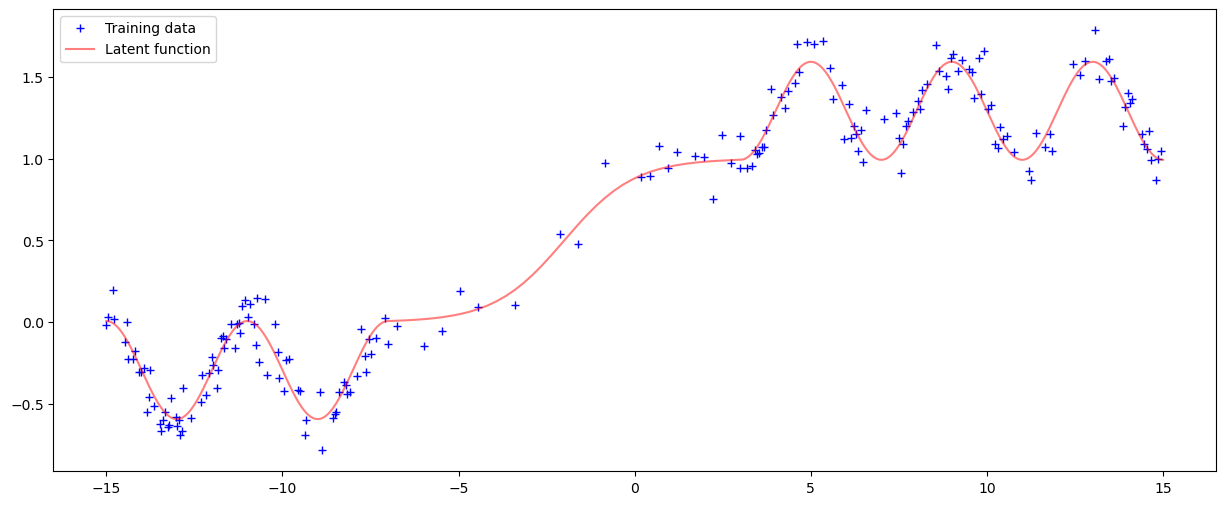

In [35]:
# generate example data
xtr,ytr,xte,yte,x_combined, y_combined=data.generate_complex_data(400,seed=1)

data.plot(xtr,ytr,x_combined, y_combined)

In [36]:
x_dim= xtr.size(1)

NKGP=cigp(xtr, ytr,NeuralKernel)
NKGP.train_adam(200,0.1)

iter 0 nll:587.46273
iter 10 nll:487.58473
iter 20 nll:389.48536
iter 30 nll:293.28745
iter 40 nll:201.79279
iter 50 nll:121.46798
iter 60 nll:64.90295
iter 70 nll:45.89953
iter 80 nll:47.93817
iter 90 nll:13.44519
iter 100 nll:-28.14225
iter 110 nll:-70.94787
iter 120 nll:-79.17112
iter 130 nll:-82.69309
iter 140 nll:-82.74963
iter 150 nll:-83.22233
iter 160 nll:-83.60012
iter 170 nll:-84.17802
iter 180 nll:-84.53064
iter 190 nll:-84.72158


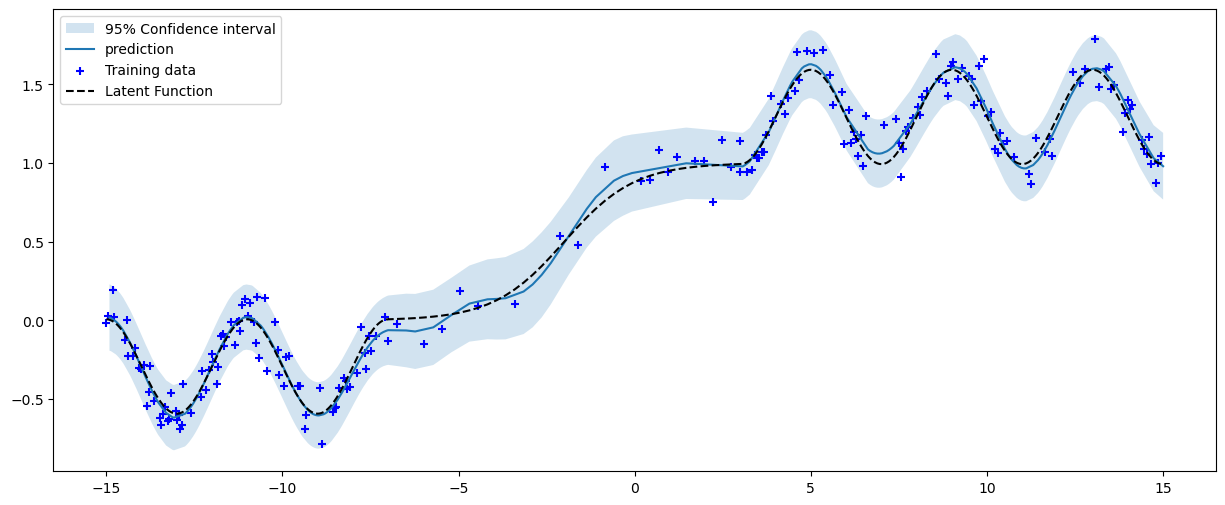

Weight for RBF kernel: 0.002457887700393516
Weight for RationalQuadratic kernel: 0.6545490508451304
Weight for linear kernel: 1.0962962398626357
Weight for periodic kernel: 0.1822676774971167


In [40]:
# Generate predictions
with torch.no_grad():
    ypred, yvar = NKGP.forward(xte)

# Sort xte and get the sorted indices
sorted_indices = torch.argsort(xte.squeeze())

# Apply the sorted indices to xte, ypred, and yvar
xte_sorted = xte[sorted_indices]
ypred_sorted = ypred[sorted_indices]
yvar_sorted = yvar[sorted_indices]

plt.figure(figsize=(15, 6))
# Plotting the predictions with error bars
plt.fill_between(
    xte_sorted.squeeze().numpy(),
    ypred_sorted.squeeze().detach().numpy() - 1.96 * np.sqrt(yvar_sorted.squeeze().detach().numpy()),
    ypred_sorted.squeeze().detach().numpy() + 1.96 * np.sqrt(yvar_sorted.squeeze().detach().numpy()),
    alpha=0.2,
    label='95% Confidence interval'
)

# Plotting the predictions
plt.plot(xte_sorted.numpy(), ypred_sorted.numpy(), label='prediction')
plt.scatter(xtr, ytr, label='Training data', color='b', marker='+')
# Adding the latent function for reference
plt.plot(x_combined.numpy(), y_combined.numpy(), 'k--', label='Latent Function')

# Adding legend
plt.legend()
plt.show()

for name, param in NKGP.kernel.weights.items():
    print(f"Weight for {name} kernel: {NKGP.kernel.softplus(param).item()}")

iter 0 nll:585.78892
iter 10 nll:487.25169
iter 20 nll:389.54931
iter 30 nll:293.58505
iter 40 nll:201.94355
iter 50 nll:121.19983
iter 60 nll:64.77184
iter 70 nll:45.96446
iter 80 nll:48.25173
iter 90 nll:46.80107
iter 100 nll:45.86380
iter 110 nll:45.99562
iter 120 nll:45.89490
iter 130 nll:45.86433
iter 140 nll:45.86951
iter 150 nll:45.86274
iter 160 nll:45.86292
iter 170 nll:45.86261
iter 180 nll:45.86240
iter 190 nll:45.86243


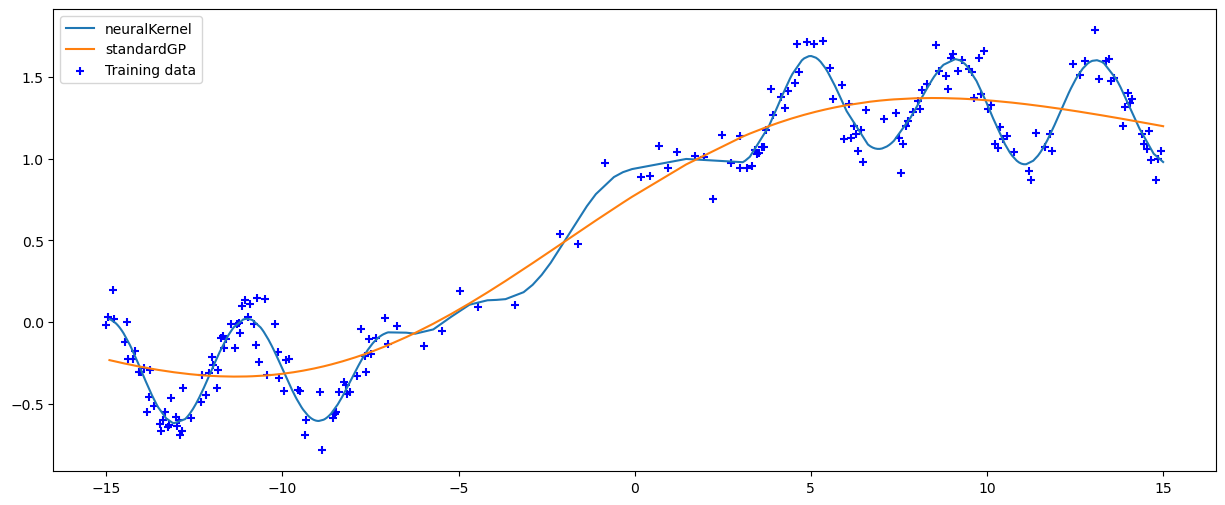

mse_neuralKernel: tensor(0.0012)
mse_standardGP: tensor(0.0442)


In [41]:
#Comparing with standard GP
standardGP=cigp(xtr, ytr,ARDKernel)
standardGP.train_adam(200,0.1)
with torch.no_grad():
    ypred2, yvar2 = standardGP.forward(xte)
mse_neuralKernel = ((yte - ypred) ** 2).mean()
mse_standardGP = ((yte - ypred2) ** 2).mean()
ypred2_sorted = ypred2[sorted_indices]
plt.figure(figsize=(15, 6))
plt.plot(xte_sorted.numpy(), ypred_sorted.numpy(), label='neuralKernel')
plt.plot(xte_sorted.numpy(), ypred2_sorted.numpy(), label='standardGP')
plt.scatter(xtr, ytr, label='Training data', color='b', marker='+')
plt.legend()
plt.show()
print('mse_neuralKernel:',mse_neuralKernel)
print('mse_standardGP:',mse_standardGP)

### Conclusion
#### The neural kernel demonstrated here is a linear combination of multiple kernels, where the weights of each kernel are learned during training. This allows the neural kernel to model complex patterns in the data effectively. In this example, the neural kernel is compared with the standard Gaussian Process (GP) with an Automatic Relevance Determination (ARD) kernel. We observe that the neural kernel GP outperforms the standard GP in this scenario. This demonstrates that the neural kernel is a simple and effective method for automatically selecting the kernel function for a GP. You can change the data to a straight line or a simple periodic function to see how the neural kernel can automatically choose the appropriate linear or periodic kernel to model the data.